In [1]:
import numpy as np
from scipy import stats

import pymc3 as pm

import torch
import pyro
import pyro.infer as infer
import pyro.distributions as dist
from torch.distributions import constraints

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
colors = sns.color_palette().as_hex()
n_colors = len(colors)

seed = 100
np.random.seed(seed)

# IQの繰り返し測定

## 問題設定

- 被験者N人がIQテストを繰り返しM回受けたとする
- M回のテストの得点のばらつきはガウス分布に従うと仮定
- ばらつきの標準偏差はテストツールの正確さに起因するとして、N人の被験者で共通と仮定
- ばらつきの平均が被験者毎の（潜在的な）真のIQに相当する

## データ

- 被験者は3人、試験回数は3とする

In [3]:
x = np.array([[90, 95, 100], 
              [105, 110, 115], 
              [150, 155, 160], 
             ])

In [4]:
N, M = x.shape

## 推論（PyMC3）

### モデルの定義

In [5]:
for v in x:
    print(v)

[ 90  95 100]
[105 110 115]
[150 155 160]


In [6]:
with pm.Model() as model:
    mu_min = 0
    mu_max = 300
    mus = pm.Uniform('mus', mu_min, mu_max, shape=N)
    
    _lam = pm.Gamma('_lam', 1., 1.)
    sigma = pm.Deterministic('sigma', 1.0/_lam)
    
    for i, x_i in enumerate(x):
        x_obs = pm.Normal(f'x_obs{i}', mu=mus[i], sigma=sigma, observed=x_i)

### 推論

In [7]:
with model:
    trace = pm.sample(1000, chains=3)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 2 jobs)
NUTS: [_lam, mus]


Sampling 3 chains for 1_000 tune and 1_000 draw iterations (3_000 + 3_000 draws total) took 8 seconds.
The acceptance probability does not match the target. It is 0.8881558936247301, but should be close to 0.8. Try to increase the number of tuning steps.


### 推論結果の確認

/usr/local/lib/python3.8/site-packages/arviz/data/io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([[<AxesSubplot:title={'center':'mus'}>,
        <AxesSubplot:title={'center':'mus'}>],
       [<AxesSubplot:title={'center':'_lam'}>,
        <AxesSubplot:title={'center':'_lam'}>],
       [<AxesSubplot:title={'center':'sigma'}>,
        <AxesSubplot:title={'center':'sigma'}>]], dtype=object)

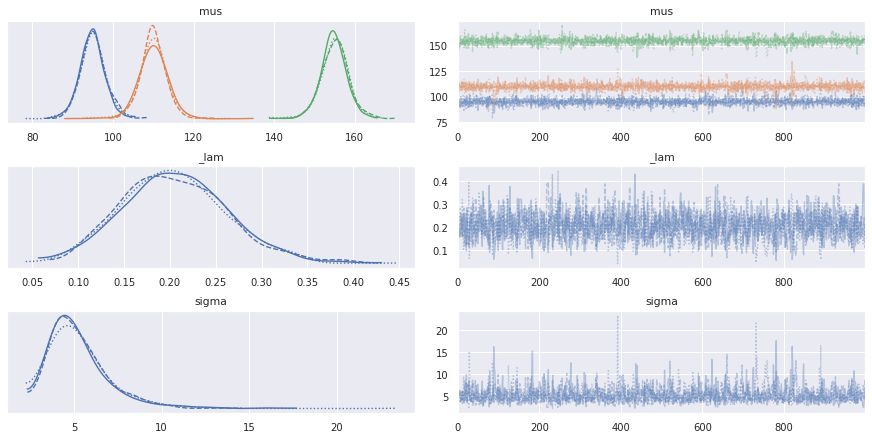

In [8]:
pm.traceplot(trace)

/usr/local/lib/python3.8/site-packages/arviz/data/io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([<AxesSubplot:title={'center':'mus\n0'}>,
       <AxesSubplot:title={'center':'mus\n1'}>,
       <AxesSubplot:title={'center':'mus\n2'}>], dtype=object)

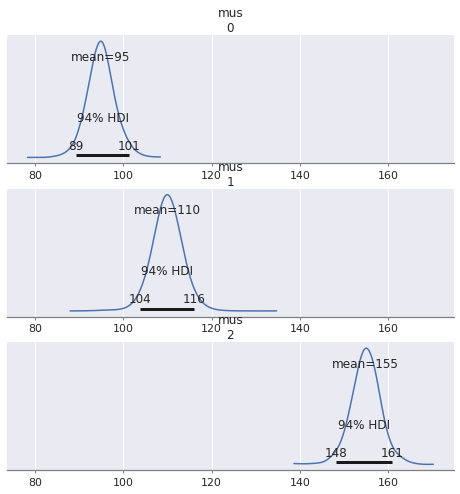

In [9]:
fig = plt.figure(figsize=(8, 8))
ax = fig.subplots(3, 1, sharex=True)

pm.plot_posterior(trace, var_names=['mus'], ax=ax)


/usr/local/lib/python3.8/site-packages/arviz/data/io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


<AxesSubplot:title={'center':'sigma'}>

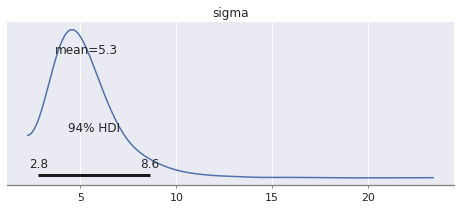

In [10]:
fig = plt.figure(figsize=(8, 3))
ax = fig.subplots(1, 1)

pm.plot_posterior(trace, var_names=['sigma'], ax=ax)


## 推論（Pyro）

### モデルの定義

In [11]:
def model_gauss(x):
    mu_min = torch.tensor(0.0)
    mu_max = torch.tensor(300.0)
    mus = []
    for i in range(len(x)):
        mus.append(pyro.sample(f'mu_{i}', dist.Uniform(mu_min, mu_max)))
    
    lam = pyro.sample('lam', dist.Gamma(torch.tensor(1.), torch.tensor(1.)))
    
    x_obs = []
    for i, x_data in enumerate(x):
        x_obs.append(pyro.sample(f'x_{i}', dist.Normal(mus[i], 1./lam), obs=x_data))
    return x_obs

### 推論

In [12]:
nuts_kernel = infer.NUTS(model_gauss, 
                         adapt_step_size=True, 
                         jit_compile=True, 
                         ignore_jit_warnings=True)
mcmc = infer.MCMC(nuts_kernel, 
                  num_samples=3000,
                  warmup_steps=500,
                  num_chains=1)

mcmc.run(torch.tensor(x))


Warmup:   0%|          | 0/3500 [00:00, ?it/s]/usr/local/lib/python3.8/site-packages/torch/tensor.py:452: RuntimeWarning: Iterating over a tensor might cause the trace to be incorrect. Passing a tensor of different shape won't change the number of iterations executed (and might lead to errors or silently give incorrect results).
  warnings.warn('Iterating over a tensor might cause the trace to be incorrect. '
Sample: 100%|██████████| 3500/3500 [00:51, 67.87it/s, step size=5.54e-01, acc. prob=0.891]


### 推論結果の確認

In [13]:
mcmc.summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
      mu_0     94.96      3.24     95.06     89.86     99.90   2290.63      1.00
      mu_1    109.93      3.15    109.97    105.19    115.15   2328.84      1.00
      mu_2    154.91      3.20    154.95    149.73    159.97   2588.10      1.00
       lam      0.21      0.06      0.20      0.11      0.30   1279.70      1.00

Number of divergences: 0


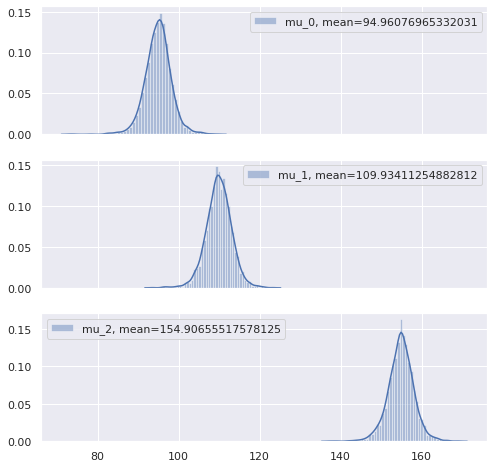

In [14]:
fig = plt.figure(figsize=(8, 8))
ax = fig.subplots(3, 1, sharex=True)

for i, _ in enumerate(x):
    mu = mcmc.get_samples()[f'mu_{i}']
    sns.distplot(mu, ax=ax[i], kde=True, 
                 label=f'mu_{i}, mean={mu.mean()}')
    ax[i].legend()

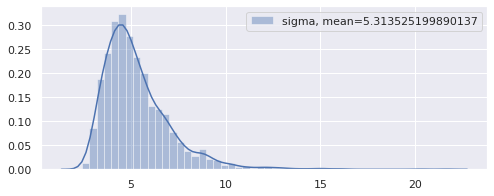

In [15]:
fig = plt.figure(figsize=(8, 3))
ax = fig.subplots(1, 1)

sig = 1./mcmc.get_samples()[f'lam']
sns.distplot(sig, ax=ax, label=f'sigma, mean={sig.mean()}')
ax.legend()